In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gs
import pandas as pd
import json

import sys
sys.path.append("/home/ci411/volume_estimation/")

import model_funcs
import torch
import os
from tqdm.notebook import tqdm

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

MODELS_DIR = '/scratch/ci411/sonos_rirs/models/'
FEATURES_DIR = '/scratch/ci411/sonos_rirs/features/'

def get_model_hist_spec_state(model_name, experiment_name):
    hist_dir = os.path.join(MODELS_DIR, experiment_name, model_name, 'hist.json')
    json_spec = os.path.join(MODELS_DIR, experiment_name, model_name, model_name+'_spec.json')
    model_state = os.path.join(MODELS_DIR, experiment_name, model_name, 'model_state.pt')
    with open(hist_dir) as f:
        hist = json.load(f)

    with open(json_spec) as f:
        spec = json.load(f)
        
    return hist, spec, model_state

Using device: cpu

Using device: cpu



In [2]:
model_name = "080522_prop0nl"
model_hist, model_spec, model_state = get_model_hist_spec_state(model_name, 'early_runs')
feature_df = pd.read_csv(model_spec['data_path'])

split = 'test'
dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']==split])

features, labels = next(iter(dataloader))
input_height = features.size()[2]
input_width = features.size()[3]

model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
model.load_state_dict(torch.load(model_state, map_location=torch.device('cpu')))

results = {}
for (x, y) in dataloader:
    (x, y) = (x.to(device), y.to(device))
    pred = model(x)
    true = y.item()
    pred = pred.item()
    
    if true in results.keys():
        results[true].append(pred)
    else:
        results[true] = [pred]
    

In [3]:
truths = list(results.keys())
truths.sort()

truth_list = []
pred_list = []
for truth in truths:
    preds = results[truth]
    
    for pred in preds:
        if pred>0:
            truth_list.append(truth)
            pred_list.append(np.log10(pred))

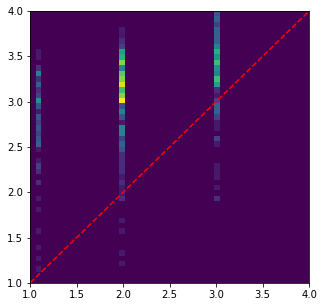

In [4]:
fig = plt.figure(figsize=(5,5))
bounds = [1,4]
bounds_pair = [bounds, bounds]
plt.xlim(bounds)
plt.ylim(bounds)
plt.plot(bounds, bounds, 'r--')

_ = plt.hist2d(truth_list, pred_list, bins=50, range=bounds_pair)

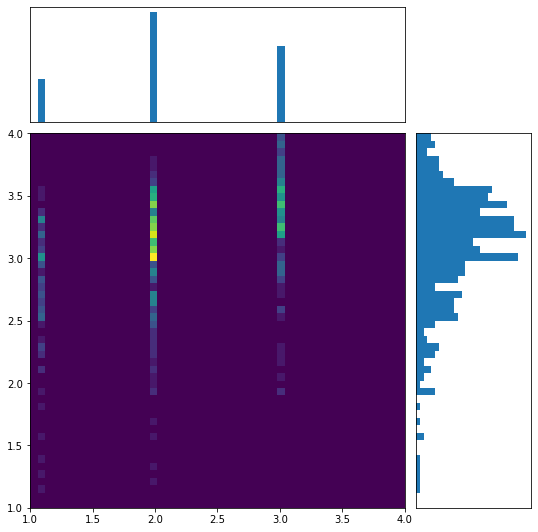

In [13]:
bins= 50
bounds = [1,4]
bounds_pair = [bounds, bounds]

# definitions for the axes
left, width = 0.1, 0.65
bottom, height = 0.1, 0.65
bottom_h = left_h = left + width + 0.02

rect_scatter = [left, bottom, width, height]
rect_histx = [left, bottom_h, width, 0.2]
rect_histy = [left_h, bottom, 0.2, height]

# start with a rectangular Figure
plt.figure(1, figsize=(8, 8))

axScatter = plt.axes(rect_scatter)
axHistx = plt.axes(rect_histx)
axHisty = plt.axes(rect_histy)

axHistx.set_xticks([])
axHistx.set_yticks([])
axHisty.set_xticks([])
axHisty.set_yticks([])

axHistx.set_xlim(bounds)
axHisty.set_ylim(bounds)

_, xedge, yedge, _ = axScatter.hist2d(truth_list, pred_list, bins=bins, range=bounds_pair)
_ = axHistx.hist(truth_list, bins=bins, range=bounds)
_ = axHisty.hist(pred_list, bins=bins, range=bounds, orientation='horizontal')

In [17]:
def generate_confusion_plot(experiment_name, model_name, split='test', savepath=None, bins=50, figside=8,\
                            bounds=[1,5], log=False, verbose=True):
    if verbose:
        print("Loading model info {}/{}...".format(experiment_name,model_name))
    model_hist, model_spec, model_state = get_model_hist_spec_state(model_name, experiment_name)
    feature_df = pd.read_csv(model_spec['data_path'])
    
    if verbose:
        print("Building {} dataloader from {}...".format(split, model_spec['data_path']))
    dataloader = model_funcs.create_dataloader(feature_df[feature_df['split']==split], log=log)

    features, labels = next(iter(dataloader))
    input_height = features.size()[2]
    input_width = features.size()[3]
    
    if verbose:
        print("Loading model weights from {}...".format(model_state))
    model = model_funcs.Baseline_Model((input_height, input_width)).to(device)
    model.load_state_dict(torch.load(model_state, map_location=torch.device('cpu')))

    
    
    results = {}
    if verbose:
        print("Running predictions...")
        
    truth_list = []
    pred_list = []
    for (x, y) in dataloader:
        (x, y) = (x.to(device), y.to(device))
        pred = model(x)
        
        
        if log:
            true = y.item()
            pred = pred.item()
        else:
            true = np.log10(y.item())
            pred = np.log10(pred.item())
                
        truth_list.append(true)
        pred_list.append(pred)

    if verbose:
        print("Plotting {} points...".format(len(truth_list)))
    
    
    fig = plt.figure(figsize=(figside,figside))
    bounds_pair = [bounds, bounds]
    
    # definitions for the axes
    left, width = 0.1, 0.65
    bottom, height = 0.1, 0.65
    bottom_h = left_h = left + width + 0.02

    rect_scatter = [left, bottom, width, height]
    rect_histx = [left, bottom_h, width, 0.2]
    rect_histy = [left_h, bottom, 0.2, height]
    
    axScatter = plt.axes(rect_scatter)
    axHistx = plt.axes(rect_histx)
    axHisty = plt.axes(rect_histy)
    
    axHistx.xaxis.set_label_position("top")
    axHistx.set_xlabel('Ground Truths')
    
    axHisty.yaxis.set_label_position("right")
    axHisty.set_ylabel('Predictions', rotation=270)

    axHistx.set_xticks([])
    axHistx.set_yticks([])
    axHisty.set_xticks([])
    axHisty.set_yticks([])
    
    axHistx.set_xlim(bounds)
    axHisty.set_ylim(bounds)

    _, xedge, yedge, _ = axScatter.hist2d(truth_list, pred_list, bins=bins, range=bounds_pair)
    axScatter.plot(bounds, bounds, 'r--')

    _ = axHistx.hist(truth_list, bins=bins, range=bounds)
    _ = axHisty.hist(pred_list, bins=bins, range=bounds, orientation='horizontal')
    plt.show()
    
    return fig

Loading model info early_runs/080522_prop0nl...
Building train dataloader from /scratch/ci411/sonos_rirs/features/080322_10k_baseline/feature_df.csv...
Loading model weights from /scratch/ci411/sonos_rirs/models/early_runs/080522_prop0nl/model_state.pt...
Running predictions...


/state/partition1/job-23405803/ipykernel_963923/710957866.py:39: RuntimeWarning: invalid value encountered in log10
  pred = np.log10(pred.item())


Plotting 8433 points...


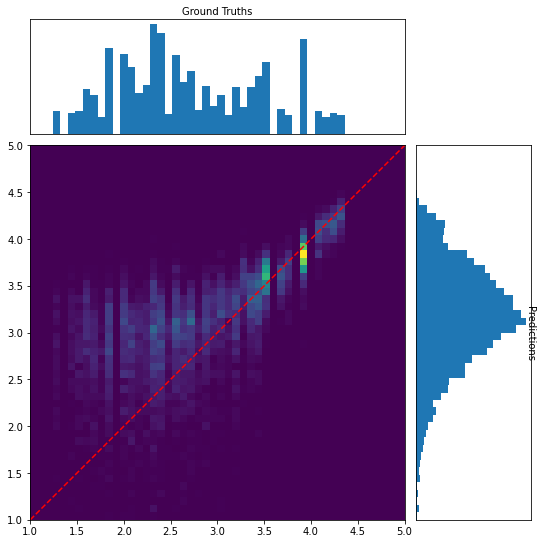

In [18]:
fig = generate_confusion_plot('early_runs', '080522_prop0nl', split='train')

Loading model info early_runs/080522_prop4nl...
Building train dataloader from /scratch/ci411/sonos_rirs/features/080322_10k_prop4/feature_df.csv...
Loading model weights from /scratch/ci411/sonos_rirs/models/early_runs/080522_prop4nl/model_state.pt...
Running predictions...


/state/partition1/job-23405803/ipykernel_963923/710957866.py:39: RuntimeWarning: invalid value encountered in log10
  pred = np.log10(pred.item())


Plotting 8433 points...


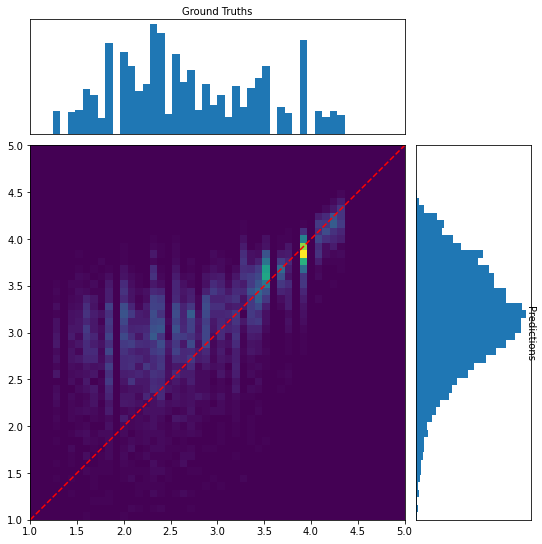

In [19]:
fig = generate_confusion_plot('early_runs', '080522_prop4nl', split='train')